In [1]:
### We create our log file

In [2]:
## %matplotlib inline
import matplotlib.pyplot as plt
import requests, re, time
from bs4 import BeautifulSoup
import scraping_class
import pprint
import pandas as pd
import numpy as np
import pickle
logfile = 'the_log.csv'## name your log file.
connector = scraping_class.Connector(logfile)
session = requests.session()
session.headers['mkp244@alumni.ku.dk'] = 'mkp244@alumni.ku.dk' 
session.headers['Oluf Kelkjær'] = 'Oluf Kelkjær'
session.headers


{'User-Agent': 'python-requests/2.21.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'mkp244@alumni.ku.dk': 'mkp244@alumni.ku.dk', 'Oluf Kelkjær': 'Oluf Kelkjær'}

In [3]:
import requests

In [4]:
url=[]
for n in range (1,5251,250):
    url.append('https://www.imdb.com/search/title/?title_type=feature&num_votes=20000,&sort=moviemeter,desc&count=250&start=' + str(n) + '&ref_=adv_nxt')

links = []
import time
for x in url:
    time.sleep(0.5)
    response = requests.get(x)
    if response.ok:
        html = response.text
    else:
        print('error')
    BeautifulSoup(html,'html.parser')
    link_location = html.split('href="')[1:]

    for link_loc in link_location:
        link = link_loc.split('"')[0].strip('title_type')      #-> check om det kan ekskluderes bagefter
        if '/title/' in link:
            links.append(link) 


links = ['https://www.imdb.com/'+link for link in links if not 'plotsummar' in link and not 'title_type' in link and not 'ref' in link and not 'plotsummary' in link and not 'vote' in link] # add the domain to each link
links=set(links)
links


{'https://www.imdb.com//title/tt0283003/',
 'https://www.imdb.com//title/tt0089893/',
 'https://www.imdb.com//title/tt0100135/',
 'https://www.imdb.com//title/tt0184858/',
 'https://www.imdb.com//title/tt0280380/',
 'https://www.imdb.com//title/tt1060277/',
 'https://www.imdb.com//title/tt4776998/',
 'https://www.imdb.com//title/tt0310775/',
 'https://www.imdb.com//title/tt2239822/',
 'https://www.imdb.com//title/tt0100419/',
 'https://www.imdb.com//title/tt0090859/',
 'https://www.imdb.com//title/tt1661382/',
 'https://www.imdb.com//title/tt0259324/',
 'https://www.imdb.com//title/tt0119250/',
 'https://www.imdb.com//title/tt0120863/',
 'https://www.imdb.com//title/tt1032846/',
 'https://www.imdb.com//title/tt2870612/',
 'https://www.imdb.com//title/tt1446714/',
 'https://www.imdb.com//title/tt0297284/',
 'https://www.imdb.com//title/tt0900387/',
 'https://www.imdb.com//title/tt0117420/',
 'https://www.imdb.com//title/tt0762125/',
 'https://www.imdb.com//title/tt2872750/',
 'https://w

In [5]:
links=set(links)
len(links)

5271

### Parsing HTML with BeautifulSoup

When parsing, we took advantage of the pyhton library BeautifulSoup. 

"BeautifulSoup makes the html tree navigable. 
It allows you to:
    * Search for elements by tag name and/or by attribute.
    * Iterate through them, go up, sideways or down the tree.
    * Furthermore it helps you with standard tasks such as extracting raw text from html,
    which would be a very tedious task if you had to hardcode it using `.split` commands and using your own regular expressions will be unstable."

In [6]:
def find_budget(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Budget:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))
        
def find_gross(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Cumulative Worldwide Gross:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))
        
def find_grossUSA(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Gross USA:":
            return float(i.text.strip().split("\n")[0].split("$")[1].replace(",", ""))

def find_rating(soup):
    for i in soup.find(id="title-overview-widget").find_all("div", class_="ratingValue"):
        return float(i.text.strip().split("/")[0])
        
def find_runtime(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Runtime:":
            return float(i.text.strip().split("\n")[1].split("min")[0].strip())
def find_date(soup):
    for i in soup.find(id="titleDetails").find_all("div", class_="txt-block"):
        if i.find().text == "Release Date:":
            return i.text.strip().split(":")[1].split("(")[0].strip()
        
def find_genre(soup):
    for i in soup.find(id="title-overview-widget").find_all("div", class_="subtext"):
        if str(i.text.strip().split("|")[2].replace('\n','').replace(' ','').split(","))[-3]==(')'):
            return i.text.strip().split("|")[1].replace('\n','').replace(' ','').split(",")
        else:
            return i.text.strip().split("|")[2].replace('\n','').replace(' ','').split(",")


### Parsing and cleaning the data 

Here we use our earlier defined functions to make a dictionary of all the data we need from the description page of each movie, ie. title, budget, the cumulative worldwide gross, the rating, the runtime, date and genre.


In [9]:
def page_extractor(url):
    r, call_id = connector.get(url, "LOL")
    try:
        soup = BeautifulSoup(r.text, "html.parser")
        title = soup.select("#title-overview-widget > div.vital > div.title_block > div > div.titleBar > div.title_wrapper > h1")[0].text.split("\xa0")[0]
        budget = find_budget(soup)
        cumulative_worldwide_gross=find_gross(soup)
        gross_usa=find_grossUSA(soup)
        rating = find_rating(soup)
        runtime = find_runtime(soup)
        date= find_date(soup)
        genre = find_genre(soup)
    except:
        soup = None
        title = None
        budget = None
        cumulative_worldwide_gross= None
        gross_usa = None
        rating=None
        runtime = None
        date = None
        genre = None
    return {
        "title": title,
        #"year": year,
        "budget": budget,
        "url": url,
        "cumulative_world_gross": cumulative_worldwide_gross,
        "gross_usa": gross_usa,
        "rating": rating,
        "runtime": runtime,
        "date": date,
        "genre": genre
    }


### Create a list and append information from every movie on the list. 
Remark: We have only chosen top 250 so far, as to not make the coding too slow in progress. If you wish to see the whole list, or a minor part of it, simply change the brackets after 'links'.



In [10]:
# res = []
# for idx, i in enumerate(links):
#     print(idx + 1, "of", len(links))
#     res.append(page_extractor(i))


### Making our list into a dataframe, and applying datetime to the releasedate

A dataframe is basically just when a list has both several columns and rows, if there's only one row it's an array.

Remember to comment on the string lengths need to be over 4 characters.


In [11]:
# df = pd.DataFrame(res).dropna()

# df = df[df['date'].str.len() > 4]

# def preparedatetime(dataframe):
#     dataframe['datetime'] = pd.to_datetime(dataframe['date'], format = '%d %B %Y')
#     dataframe['year'] = dataframe.datetime.dt.year
#     dataframe['month'] = dataframe.datetime.dt.month
#     dataframe['day'] = dataframe.datetime.dt.day
#     return dataframe

# df = preparedatetime(df)
# df
# df.to_pickle('all_movies.csv') #saves relatively as csv 
#df.to_pickle('all_movies.pkl')
# #This command will load dataset from pkl or csv file
# df = pd.read_pickle('all_movies.csv')
# # or
df = pd.read_pickle('all_movies.pkl')
df

,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,title,url,datetime,year,month,day
1,110000000.0,7.122059e+08,17 November 2011,"[Action, Adventure, Drama]",281287133.0,4.9,117.0,Breaking Dawn - del 1,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,11,17
2,3500000.0,1.950404e+07,29 September 2011,"[Drama, Thriller]",5354039.0,7.1,107.0,Giftig viden,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,9,29
3,56600000.0,6.942439e+07,21 January 2005,"[Drama, Mystery, Romance]",6524389.0,7.6,133.0,En lang forlovelse,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,1,21
4,175000000.0,1.734188e+08,27 July 2007,"[Comedy, Family, Fantasy]",100462298.0,5.4,96.0,"Du almægtige, Evan",https://www.imdb.com//title/tt0413099/,2007-07-27,2007,7,27
6,8000000.0,1.005232e+08,17 November 2006,"[Comedy, Drama]",59891098.0,7.8,101.0,Little Miss Sunshine,https://www.imdb.com//title/tt0449059/,2006-11-17,2006,11,17
7,78000000.0,1.792652e+08,26 September 2003,"[Action, Adventure, Fantasy]",66465204.0,5.8,110.0,Det hemmelighedsfulde selskab,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,9,26
8,25000000.0,1.341196e+07,3 June 2005,"[Biography, Drama, Sport]",11273517.0,7.1,107.0,Lords of Dogtown,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,6,3
9,14000000.0,1.434303e+07,24 May 2002,[Comedy],14254993.0,4.6,87.0,Freddy Got Fingered,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,5,24
10,15000000.0,8.064053e+07,25 March 1988,"[Comedy, Drama, Romance]",80640528.0,7.1,102.0,Lunefulde måne,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,3,25
12,12000000.0,5.222331e+07,29 November 2002,"[Drama, Thriller]",31597131.0,6.8,96.0,One Hour Photo,https://www.imdb.com//title/tt0265459/,2002-11-29,2002,11,29


In [12]:
categories = set()
for i in df["genre"].apply(set).tolist():
    for j in i:
        categories.add(j)
#categories= set(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
#                'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
#                'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller'])
df2 = pd.concat([df, pd.DataFrame(columns=categories)], axis=1)


In [13]:
def df_dummy(df, col):
    return df.apply(lambda x: col in x["genre"], axis=1)

for i in categories:
    df2[i] = df_dummy(df2, i)
    df2[i] = pd.get_dummies(df2[i], drop_first = True)


df2 = df2.set_index(df['title'])
del df2['title']

df2


,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,url,datetime,year,...,Crime,Horror,Music,Musical,Action,History,Comedy,Adventure,Thriller,Family
title,,,,,,,,,,,,,,,,,,,,,
Breaking Dawn - del 1,110000000.0,7.122059e+08,17 November 2011,"[Action, Adventure, Drama]",281287133.0,4.9,117.0,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,...,0,0,0,0,1,0,0,1,0,0
Giftig viden,3500000.0,1.950404e+07,29 September 2011,"[Drama, Thriller]",5354039.0,7.1,107.0,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,...,0,0,0,0,0,0,0,0,1,0
En lang forlovelse,56600000.0,6.942439e+07,21 January 2005,"[Drama, Mystery, Romance]",6524389.0,7.6,133.0,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,...,0,0,0,0,0,0,0,0,0,0
"Du almægtige, Evan",175000000.0,1.734188e+08,27 July 2007,"[Comedy, Family, Fantasy]",100462298.0,5.4,96.0,https://www.imdb.com//title/tt0413099/,2007-07-27,2007,...,0,0,0,0,0,0,1,0,0,1
Little Miss Sunshine,8000000.0,1.005232e+08,17 November 2006,"[Comedy, Drama]",59891098.0,7.8,101.0,https://www.imdb.com//title/tt0449059/,2006-11-17,2006,...,0,0,0,0,0,0,1,0,0,0
Det hemmelighedsfulde selskab,78000000.0,1.792652e+08,26 September 2003,"[Action, Adventure, Fantasy]",66465204.0,5.8,110.0,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,...,0,0,0,0,1,0,0,1,0,0
Lords of Dogtown,25000000.0,1.341196e+07,3 June 2005,"[Biography, Drama, Sport]",11273517.0,7.1,107.0,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,...,0,0,0,0,0,0,0,0,0,0
Freddy Got Fingered,14000000.0,1.434303e+07,24 May 2002,[Comedy],14254993.0,4.6,87.0,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,...,0,0,0,0,0,0,1,0,0,0
Lunefulde måne,15000000.0,8.064053e+07,25 March 1988,"[Comedy, Drama, Romance]",80640528.0,7.1,102.0,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,...,0,0,0,0,0,0,1,0,0,0


## Code for plots

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

#plt.style.use('ggplot')
plt.style.use('default')
%matplotlib inline

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Ratings function (main function)
## Will scrape each ranking URL from relevant data.
### Title is gathered by selector while the rankings are gathered by HTML converted into list which then is calculated

In [15]:
################### sub function making a list and from list created variables in main function ###################
def find_ratings(soup, rate):        
    for i in soup.select("#main > section > div > table:nth-child(14)")[0].find_all('div', class_='bigcell'):
        rate.append(i.text)
# find_ratings(BeautifulSoup(requests.get("https://www.imdb.com//title/tt0266543/ratings").text, "html.parser"))        
# rate


def ratings_extractor(url):
    r_r, call_id = connector.get(url, "ROFLMAO")
    soup_ = BeautifulSoup(requests.get(url).text, "html.parser")
    rate = []
    try:
        title = soup_.select("#main > section > div > div.subpage_title_block > div > div.parent > h3 > a")[0].text
        find_ratings(soup_,rate)
        check = [float(i) for i in rate]
        rate_all = [float(i) for i in rate][0]
        rate_young = float(round(np.array(list(np.array([float(i) for i in rate])[[1, 2, 6, 7, 11, 12]])).sum()/6, 2)) 
        rate_old = float(round(np.array((np.array([float(i) for i in rate])[[3,4,8,9,13,14]])).sum()/6, 2))
        rate_male = [float(i) for i in rate][5]
        rate_female = [float(i) for i in rate][10]
    except:
        title = None
        rate_all = None
        rate_young = None
        rate_old = None
        rate_male = None
        rate_female = None
    return {
        'title': title,
        'rate_all': rate_all,
        'rate_young': rate_young,
        'rate_old': rate_old,
        'rate_male': rate_male,
        'rate_female': rate_female
        }
ratings_extractor('https://www.imdb.com//title/tt0218817/ratings') #fordi den bliver None, skal de fjernes efter

{'rate_all': None,
 'rate_female': None,
 'rate_male': None,
 'rate_old': None,
 'rate_young': None,
 'title': None}

# Gathering all titles and their rankings using main function. 
## Each ranking url has it's own dictionary. Each dictionary is stored as a list

In [16]:
# rankings for each films are stored in links_r
links_r = [x+'ratings' for x in links]
res_r = []
# for idx, i in enumerate(links_r):
#     print(idx + 1, "of", len(links_r))
#     res_r.append(ratings_extractor(i))
    
    

# links_r[26] #det er link nummer 27 der forvolder problemer

# Translating the list of dictionaries into a DataFrame
## rankings-DataFrame

In [17]:
# df_r = pd.DataFrame(res_r).dropna() #dropper de film der mangler ratings fra en bestemt gruppe


# df_r.to_pickle('all_ratings.pkl') #husk kun at brug når data skal uploades/gemmes
df_r = pd.read_pickle('all_ratings.pkl').dropna() #husk kun at brug når data skal downloades/hentes
df_r = df_r.set_index(df_r['title'], drop=True)
del df_r['title']
df_r



,rate_all,rate_female,rate_male,rate_old,rate_young
title,,,,,
Recep Ivedik,4.6,3.5,4.8,4.27,4.83
Breaking Dawn - del 1,4.9,5.8,4.3,5.13,5.18
Giftig viden,7.1,6.9,7.1,7.12,7.20
En lang forlovelse,7.6,7.7,7.6,7.63,8.38
"Du almægtige, Evan",5.4,5.6,5.3,5.53,5.67
Hotel Mumbai,7.6,7.9,7.5,7.60,7.97
Little Miss Sunshine,7.8,7.9,7.8,7.80,7.98
Det hemmelighedsfulde selskab,5.8,6.2,5.8,5.90,5.95
Lords of Dogtown,7.1,7.3,7.1,6.93,7.40


# Merging movie-attribute-DataFrame with rankings-DataFrame, using innerjoin on the movie titles

In [18]:
df_master = pd.merge(df2, df_r, on='title', how='inner')

df_master = df_master.drop("Fetih 1453", axis=0)
df_master['cumulative_world_gross']=round(df_master['cumulative_world_gross']/1000000,3)
df_master['budget']=df_master['budget']/1000000
df_master['profit']=(df_master['cumulative_world_gross']-df_master['budget'])
df_master['return'] = round(df_master['cumulative_world_gross']/df_master['budget'],2)
df_master['gross_usa']=round(df_master['gross_usa']/1000000,2)
df_master

#drop outlier ift. return. alt under 0,3 altså 70 pct. tab er outlier samt alt over 10
# df_master=df_master.drop(df_master[df_master['return'] < 0.4].index)
df_master = df_master.drop(df_master[df_master['return'] > 10].index)
# df_master = df_master.drop((df_master['return'] > 20).index, inplace=True)

df_master
#note that https://www.imdb.com//title/tt1783232/ has a budget of 18 dollars while grossing 35 million dollar.
# df_master.loc[df_master['return'].idxmax()]
#It should've been 18 mio according to google.
#skær jf. fordeling



,budget,cumulative_world_gross,date,genre,gross_usa,rating,runtime,url,datetime,year,...,Adventure,Thriller,Family,rate_all,rate_female,rate_male,rate_old,rate_young,profit,return
title,,,,,,,,,,,,,,,,,,,,,
Breaking Dawn - del 1,110.0,712.206,17 November 2011,"[Action, Adventure, Drama]",281.29,4.9,117.0,https://www.imdb.com//title/tt1324999/,2011-11-17,2011,...,1,0,0,4.9,5.8,4.3,5.13,5.18,602.206,6.47
Giftig viden,3.5,19.504,29 September 2011,"[Drama, Thriller]",5.35,7.1,107.0,https://www.imdb.com//title/tt1615147/,2011-09-29,2011,...,0,1,0,7.1,6.9,7.1,7.12,7.20,16.004,5.57
En lang forlovelse,56.6,69.424,21 January 2005,"[Drama, Mystery, Romance]",6.52,7.6,133.0,https://www.imdb.com//title/tt0344510/,2005-01-21,2005,...,0,0,0,7.6,7.7,7.6,7.63,8.38,12.824,1.23
"Du almægtige, Evan",175.0,173.419,27 July 2007,"[Comedy, Family, Fantasy]",100.46,5.4,96.0,https://www.imdb.com//title/tt0413099/,2007-07-27,2007,...,0,0,1,5.4,5.6,5.3,5.53,5.67,-1.581,0.99
Det hemmelighedsfulde selskab,78.0,179.265,26 September 2003,"[Action, Adventure, Fantasy]",66.47,5.8,110.0,https://www.imdb.com//title/tt0311429/,2003-09-26,2003,...,1,0,0,5.8,6.2,5.8,5.90,5.95,101.265,2.30
Lords of Dogtown,25.0,13.412,3 June 2005,"[Biography, Drama, Sport]",11.27,7.1,107.0,https://www.imdb.com//title/tt0355702/,2005-06-03,2005,...,0,0,0,7.1,7.3,7.1,6.93,7.40,-11.588,0.54
Freddy Got Fingered,14.0,14.343,24 May 2002,[Comedy],14.25,4.6,87.0,https://www.imdb.com//title/tt0240515/,2002-05-24,2002,...,0,0,0,4.6,3.9,4.7,4.00,4.87,0.343,1.02
Lunefulde måne,15.0,80.641,25 March 1988,"[Comedy, Drama, Romance]",80.64,7.1,102.0,https://www.imdb.com//title/tt0093565/,1988-03-25,1988,...,0,0,0,7.1,7.3,7.0,7.18,7.52,65.641,5.38
One Hour Photo,12.0,52.223,29 November 2002,"[Drama, Thriller]",31.60,6.8,96.0,https://www.imdb.com//title/tt0265459/,2002-11-29,2002,...,0,1,0,6.8,6.6,6.8,6.67,7.22,40.223,4.35


In [19]:
def category_summary(df, category, categories):
    categories = list(categories)
    stats = ["rate_all", "rate_female", "rate_male", "rate_old", "rate_young"]
    df_ = df[stats + categories]
    df_ = df_[df_[category] == 1]
    return df_[stats].mean() 




# print(category_summary(df_master, "Fantasy", ["Fantasy"])) #examples
# print(category_summary(df_master, "Horror", ["Horror"])) #exmaples

rated = []
for idx, i in enumerate(categories):
    print(idx+1, 'of', len(categories))
    rated.append(category_summary(df_master, i, [i]))
    
# rated 
df_rated=pd.DataFrame(rated, index=categories)
df_rated

#Check at categories er defineret ud fra hvilke genre der rent faktisk er i datasættet

1 of 21
2 of 21
3 of 21
4 of 21
5 of 21
6 of 21
7 of 21
8 of 21
9 of 21
10 of 21
11 of 21
12 of 21
13 of 21
14 of 21
15 of 21
16 of 21
17 of 21
18 of 21
19 of 21
20 of 21
21 of 21


,rate_all,rate_female,rate_male,rate_old,rate_young
Animation,6.877387,7.059296,6.817085,6.834372,6.925578
Mystery,6.588514,6.639527,6.570608,6.550642,6.736419
Drama,6.948579,7.025572,6.900000,6.892093,7.161476
Fantasy,6.399677,6.595161,6.334194,6.406323,6.563323
Film-Noir,8.200000,8.100000,8.200000,8.185000,8.375000
Western,7.223529,7.188235,7.211765,7.178235,7.417647
Biography,7.221101,7.323394,7.178440,7.187110,7.436284
Romance,6.588106,6.711454,6.495154,6.527974,6.829802
Sci-Fi,6.486392,6.543354,6.467722,6.461487,6.537278
War,7.446939,7.497959,7.420408,7.394082,7.633265


In [20]:
def genre_stats(df, category, categories):
    categories = list(categories)
    stats = ["cumulative_world_gross", "budget", 'rating']
    df_ = df[stats + categories]
    df_ = df_[df_[category] == 1]
    return df_[stats].mean() 
#husk at inkluder antallet af observationer pr. genre

# print(genre_stats(df_master, "Musical", ["Musical"]))


money = []
for idx, i in enumerate(categories):
    money.append(genre_stats(df_master, i, [i]))
    
# rated 
df_money=pd.DataFrame(money, index=categories)
df_money['genres']=categories
df_money['cumulative_world_gross']=round(df_money['cumulative_world_gross'],2)
df_money['budget']=round(df_money['budget'],2)
df_money['profit']=(df_money['cumulative_world_gross']-df_money['budget'])
df_money['return']=round(df_money['cumulative_world_gross']/df_money['budget'],2)
df_money['rating']=round(df_money['rating'],2)

df_money

,cumulative_world_gross,budget,rating,genres,profit,return
Animation,292.58,84.21,6.88,Animation,208.37,3.47
Mystery,85.96,31.83,6.55,Mystery,54.13,2.70
Drama,80.62,32.94,6.94,Drama,47.68,2.45
Fantasy,176.95,61.48,6.39,Fantasy,115.47,2.88
Film-Noir,1.29,1.29,8.20,Film-Noir,0.00,1.00
Western,55.56,29.84,7.22,Western,25.72,1.86
Biography,72.54,31.02,7.23,Biography,41.52,2.34
Romance,85.15,30.35,6.57,Romance,54.80,2.81
Sci-Fi,189.64,66.16,6.48,Sci-Fi,123.48,2.87
War,72.45,29.13,7.45,War,43.32,2.49


In [21]:
df_master.describe()
df_master['return'].describe()

count    3060.000000
mean        2.908212
std         2.241529
min         0.000000
25%         1.200000
50%         2.325000
75%         4.020000
max        10.000000
Name: return, dtype: float64

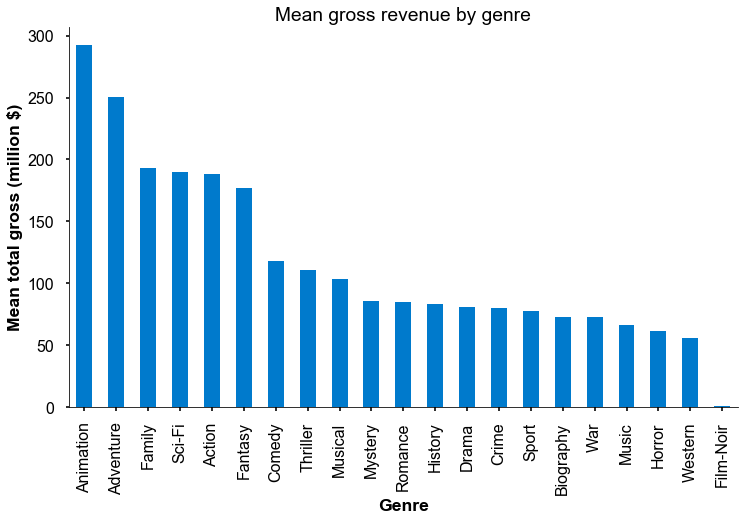

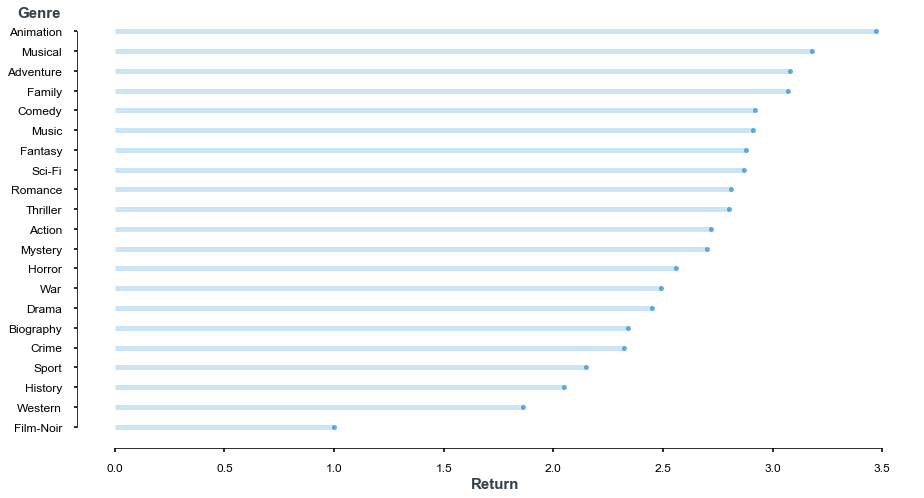

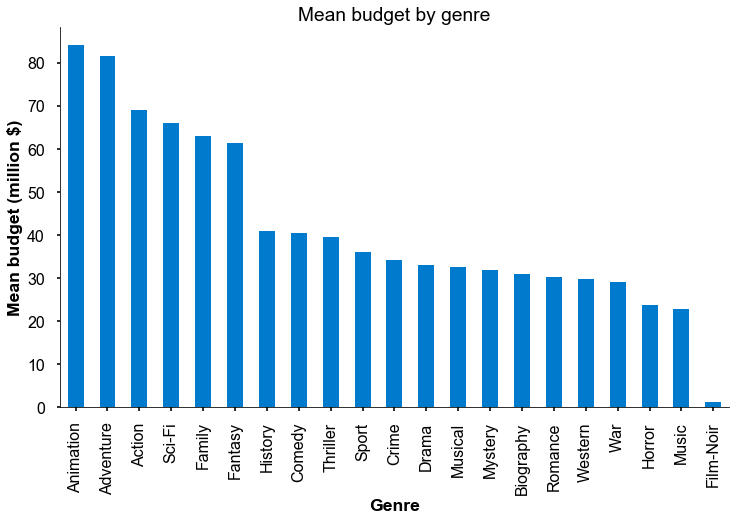

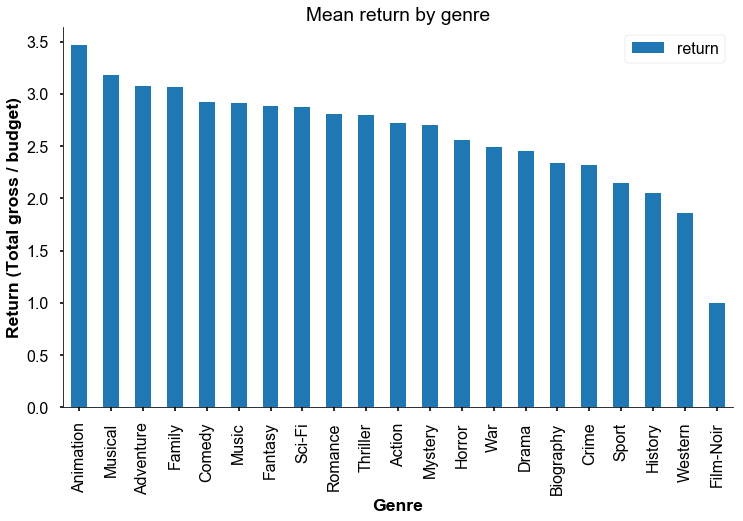

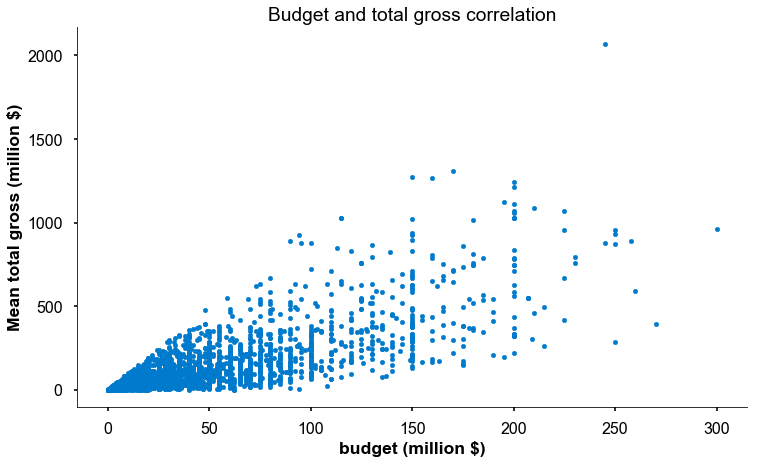

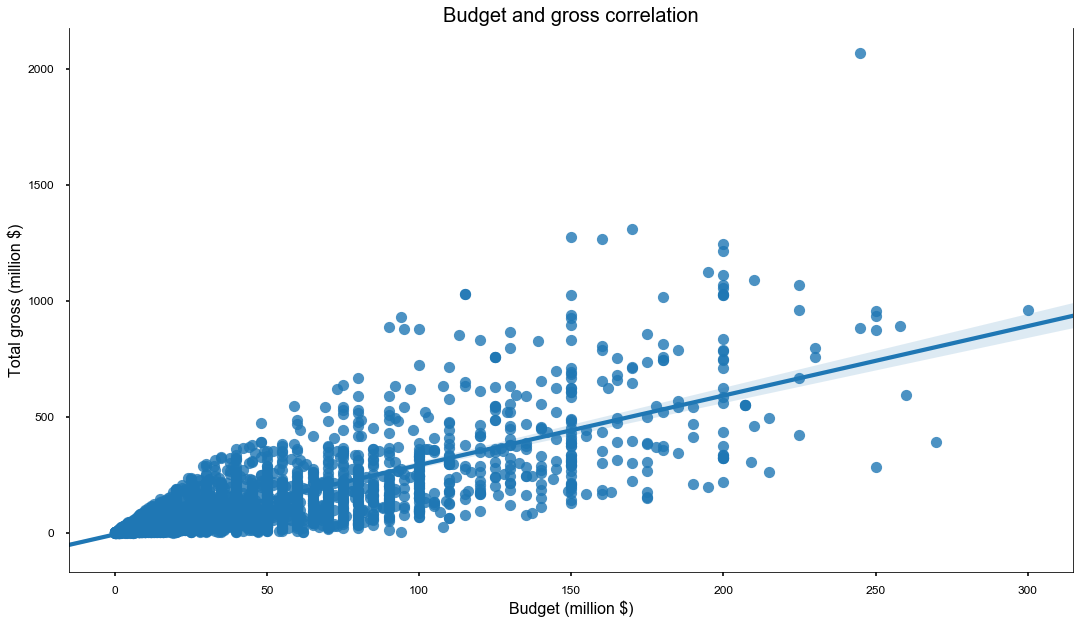

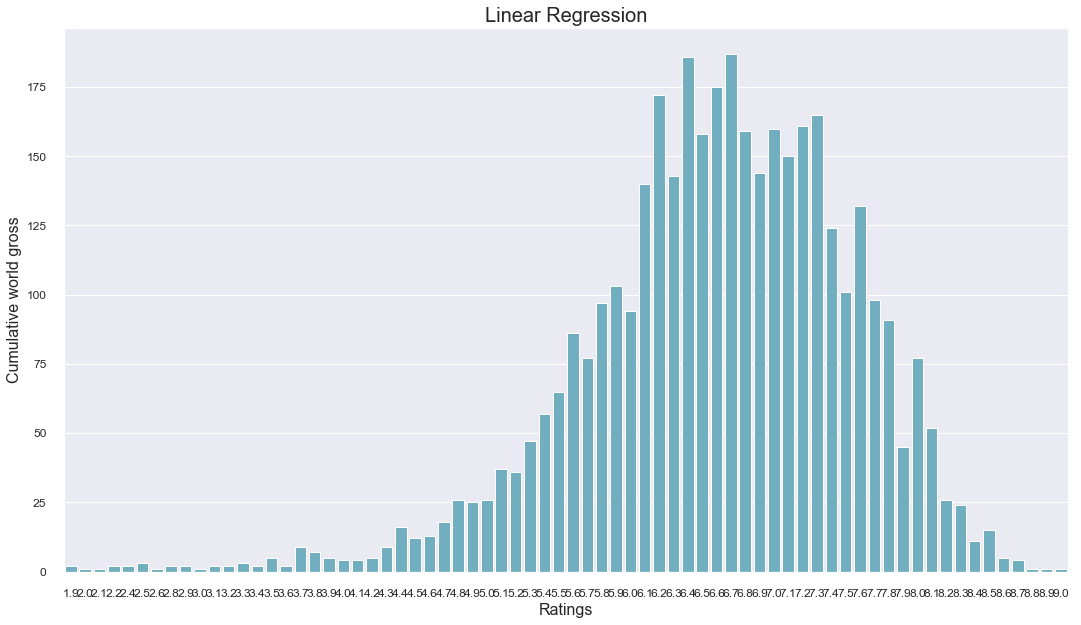

In [22]:
import matplotlib.style as style
style.use('seaborn-poster')
%matplotlib inline
barplot1 = df_money.sort_values('cumulative_world_gross', ascending=False).plot.bar(x='genres', y='cumulative_world_gross', title='Mean gross revenue by genre', legend=False, color = '#007ACC', figsize=(12,7))
# barplot[0].set_color('red')
barplot1.set_ylabel('Mean total gross (million $)', weight='bold')
barplot1.set_xlabel('Genre', weight='bold')
barplot1.spines['top'].set_visible(False)
barplot1.spines['right'].set_visible(False)


#virker ikke længere ordentligt da jeg gik fra ggplot til classic
df_money = df_money.sort_values(by='return')
my_range = list(range(1,len(df_money.index)+1))
fig, ax = plt.subplots(figsize=(15,8))
plt.hlines(y=my_range, xmin=0, xmax=df_money['return'], color='#007acc', alpha=0.2, linewidth=5)
plt.plot(df_money['return'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)
ax.set_xlabel('Return', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df_money.index)
fig.text(0.07, 0.87, 'Genre', fontsize=15, fontweight='black', color = '#333F4B')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
ax.spines['bottom'].set_position(('axes', -0.004))
ax.spines['left'].set_position(('axes', 0))



barplot2 = df_money.sort_values('budget', ascending=False).plot.bar(x='genres', y='budget', title='Mean budget by genre', legend=False, color = '#007ACC', figsize=(12,7))
# barplot[0].set_color('red')
barplot2.set_ylabel('Mean budget (million $)', weight='bold')
barplot2.set_xlabel('Genre', weight='bold')
barplot2.spines['top'].set_visible(False)
barplot2.spines['right'].set_visible(False)

barplot3 = df_money.sort_values('return', ascending=False).plot.bar(x='genres', y='return', figsize=(12,7), title='Mean return by genre')
barplot3.set_ylabel('Return (Total gross / budget)', weight='bold')
barplot3.set_xlabel('Genre', weight='bold')
barplot3.spines['top'].set_visible(False)
barplot3.spines['right'].set_visible(False)



scatter1 = df_master.plot.scatter(x='budget', y='cumulative_world_gross', title='Budget and total gross correlation', legend=False, color = '#007ACC', figsize=(12,7))
# barplot[0].set_color('red')
scatter1.set_ylabel('Mean total gross (million $)', weight='bold')
scatter1.set_xlabel('budget (million $)', weight='bold')
scatter1.spines['top'].set_visible(False)
scatter1.spines['right'].set_visible(False)



# scatter1= sns.regplot(x='sepal_length', y='petal_length', order=2, data=iris)
# plt.xlabel('Sepal length');
# plt.ylabel('Petal length');
# plt.title('Scatterplot of petal and sepal length, 2nd polynomial');

# scatter2 = df_master.plot.scatter(x='rating', y='return', title='Rating and return', legend=False, color = '#007ACC', figsize=(12,7))
# # barplot[0].set_color('red')
# scatter2.set_ylabel('Return (gross/budget)', weight='bold')
# scatter2.set_ylim([0,12])
# scatter2.set_xlabel('Rating', weight='bold')
# scatter2.spines['top'].set_visible(False)
# scatter2.spines['right'].set_visible(False)



# Første plot - viser ingen klar sammenhæng
fig, ax = plt.subplots(figsize = (18,10))
ax = sns.regplot(x="budget", y="cumulative_world_gross", data=df_master) # HVAD SKER DER FOR Y-AKSEN ?? Hvorfor er så mange film på 0,0?
ax = plt.gca()
ax.set_xlabel('Budget (million $)')
ax.set_ylabel('Total gross (million $)')
ax.set_title('Budget and gross correlation')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
ax.spines['top'].set_visible(False)
for item in ax.get_yticklabels()+ax.get_xticklabels():
    item.set_fontsize(12)   


# Andet plot
import seaborn as sns; sns.set(color_codes=True)
fig, ax = plt.subplots(figsize = (18,10))
ax = sns.countplot(x="rating", data=df2, color="c") # HVAD SKER DER FOR Y-AKSEN ?? Hvorfor er så mange film på 0,0?
ax = plt.gca()
ax.set_xlabel('Ratings')
ax.set_ylabel('Cumulative world gross')
ax.set_title('Linear Regression')
ax.title.set_fontsize(20)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
for item in ax.get_yticklabels()+ax.get_xticklabels():
    item.set_fontsize(12)





In [23]:
df_master['return'].describe()

count    3060.000000
mean        2.908212
std         2.241529
min         0.000000
25%         1.200000
50%         2.325000
75%         4.020000
max        10.000000
Name: return, dtype: float64

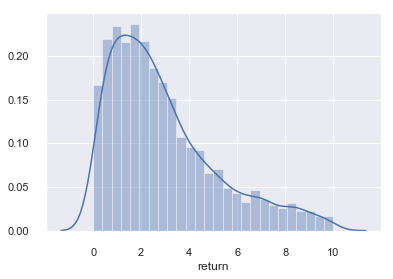

In [24]:
# ax1 = plt.boxplot(df_master['return'], data=df_master)
sns.distplot(df_master['return'])


# boxlot1 = plt-boxplot('return', data=df_master, title='Boxplot of return', legend=False, color = '#007ACC')
# boxplot1.set_ylabel('Return (Total gross / budget)', weight='bold')
# boxplot1.set_ylim([0,12])
# df_master.plot()
# plt.show()


## ML
**Importing packages/modules**

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Return
## Seperating the dataset into features and dependent variable

In [26]:
X_r = df_master[['rating', 'runtime', *list(categories)]].values
y_r = df_master['cumulative_world_gross']/df_master['budget'].values

## Creating a baseline for our predictions

We divide dataset into test and development.
Afterwards we seek to compare our Lasso OLS model with 2 baseline model. One model which always guess the mean value of return.
Another which is a simple linear model.

In [27]:
#splitting data
X_r_dev, X_r_test, y_r_dev, y_r_test = train_test_split(X_r, y_r, test_size=1/3, random_state=1)

In [28]:
def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

yr_pred_mean = np.repeat(y_r_dev.mean(),y_r_test.shape[0])
baseline1_r_rmse = rmse(yr_pred_mean,y_r_test)
baseline1_r_rmse

2.314001005790378

In [29]:
yr_pred_linreg = LinearRegression().fit(X_r_dev,y_r_dev).predict(X_r_test)
baseline2_r_rmse = rmse(yr_pred_linreg,y_r_test)
baseline2_r_rmse

2.239996410648766

In [30]:
# Med K-fold
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_r_dev, y_r_dev))
lambdas = np.logspace(-4, 1, 20)
rmseCV=[]
for lambda_ in lambdas:
    rmseCV_=[]
    for train_idx, val_idx in folds:
        pipe_lassoCV = make_pipeline(ColumnTransformer(
                                    [('Continous', make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures()),
                                    [0,1]),
                                    ('','passthrough', [i for i in range(2, X_r.shape[1])])]),
                                    Lasso(alpha=lambda_, random_state=1))
        X_r_train, y_r_train = X_r_dev[train_idx], y_r_dev[train_idx]
        X_r_val, y_r_val = X_r_dev[val_idx], y_r_dev[val_idx]
        pipe_lassoCV.fit(X_r_train, y_r_train)
        rmseCV_.append(rmse(pipe_lassoCV.predict(X_r_val),y_r_val))
        
    rmseCV.append(sum(rmseCV_)/len(rmseCV_))
    
lambdaCV=pd.DataFrame(rmseCV, index=lambdas)
lambdaCV
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
optimal_lambda

0.023357    2.134097
dtype: float64

In [31]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV,
                     X=X_r_dev,
                     y=y_r_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
0.023357    4.585619
Name: Validation, dtype: float64


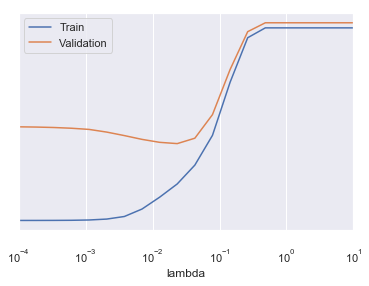

In [32]:
mse_score.plot(logx=True, logy=True)
#the model will improve as some features are removed and will worsen as all features are removed.

In [33]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV,
                   X=X_r_train,
                   y=y_r_train,
                   train_sizes=np.arange(0.2, 1.0, .01),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    
print(mse_.head(3))

                Train      Test
sample size                    
244          4.186001  4.901488
257          4.261699  4.900626
269          4.211437  4.893707


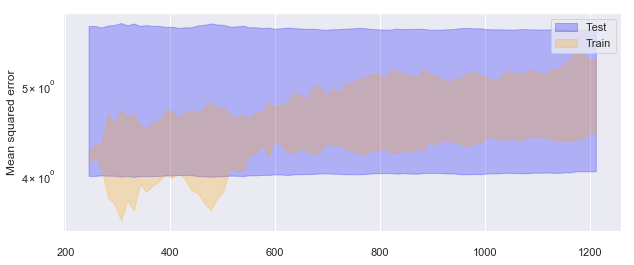

In [34]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

In [35]:
#LASSO PIPE WITH OPTIMAL LAMBDA
pipe_optimal_r = make_pipeline(ColumnTransformer(
                                    [("Continous", make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures()),
                                    [0,1]), 
                                    ("", 'passthrough', [i for i in range(2, X_r.shape[1])])]),
                                    Lasso(alpha=0.023357, random_state=1))
fit_r = pipe_optimal_r.fit(X_r_dev, y_r_dev)
ml_r_rmse=rmse(fit_r.predict(X_r_test),y_r_test)
print('RMSE, Mean prediction model:', baseline1_r_rmse)
print('RMSE, simple linear model:', baseline2_r_rmse)
print('RMSE, ML lasso CV:', ml_r_rmse)

RMSE, Mean prediction model: 2.314001005790378
RMSE, simple linear model: 2.239996410648766
RMSE, ML lasso CV: 2.2423572135970735


In [36]:
#Checking their average deviation from prediction:
def mean_abs_err(y_pred,y_test) :
    return np.mean(np.abs(y_test - y_pred))

yr_pred_ml=fit_r.fit(X_r_dev, y_r_dev).predict(X_r_test)

print('AD, Mean prediction model:', mean_abs_err(yr_pred_mean,y_r_test))
print('AD, linear model:', mean_abs_err(yr_pred_linreg,y_r_test))
print('AD, ML model:', mean_abs_err(yr_pred_ml,y_r_test))

AD, Mean prediction model: 1.7793754763399536
AD, linear model: 1.6976241576172781
AD, ML model: 1.6964126438059184


# Total gross
## Seperating the dataset into features and dependent variable

In [37]:
X = df_master[['budget', 'rating', 'runtime', *list(categories)]].values
y = df_master['cumulative_world_gross'].values

## Dividing dataset into development and test

In [38]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)

## Creating 2 baseline models in order to compare ML model

In [39]:
y_pred_mean = np.repeat(y_dev.mean(),y_test.shape[0])
baseline1_rmse = rmse(y_pred_mean,y_test)
baseline1_rmse

161.89771982934025

In [51]:
y_pred_linreg = LinearRegression().fit(X_dev,y_dev).predict(X_test)
baseline2_rmse = rmse(y_pred_linreg,y_test)
baseline2_rmse

101.71603013996534

In [48]:
# LASSO med K-fold
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
lambdas = np.logspace(-1, 3, 20)
rmseCV=[]
for lambda_ in lambdas:
    rmseCV_=[]
    for train_idx, val_idx in folds:
        pipe_lassoCV_ = make_pipeline(ColumnTransformer(
                                    [('Continous', make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures()),
                                    [0,2]),
                                    ('','passthrough', [i for i in range(3, X.shape[1])])]),
                                    Lasso(alpha=lambda_, random_state=1))
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]
        pipe_lassoCV_.fit(X_train, y_train)
        rmseCV_.append(rmse(pipe_lassoCV_.predict(X_val),y_val))
        
    rmseCV.append(sum(rmseCV_)/len(rmseCV_))
    
lambdaCV=pd.DataFrame(rmseCV, index=lambdas)
lambdaCV
optimal_lambda = lambdaCV.mean(axis=1).nsmallest(1)
optimal_lambda

0.428133    106.856784
dtype: float64

In [49]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = \
    validation_curve(estimator=pipe_lassoCV_,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',                 
                     cv=3)

mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
0.695193    11757.044912
Name: Validation, dtype: float64


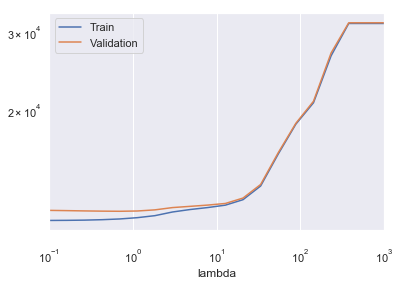

In [50]:
mse_score.plot(logx=True, logy=True)

In [44]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lassoCV_,
                   X=X_train,
                   y=y_train,
                   train_sizes=np.arange(0.2, 1, .01),
                   scoring='neg_mean_squared_error',                 
                   cv=3)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))    

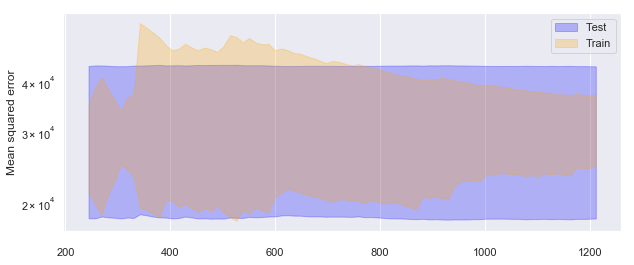

In [45]:
f_learn, ax = plt.subplots(figsize=(10,4))
ax.fill_between(train_sizes,
                -test_scores.mean(1) + test_scores.std(1)*1.96,
                -test_scores.mean(1) - test_scores.std(1)*1.96, 
                alpha=0.25, label ='Test', color='blue')

ax.fill_between(train_sizes,
                -train_scores.mean(1) + train_scores.std(1)*1.96,
                -train_scores.mean(1) - train_scores.std(1)*1.96, 
                alpha=0.25, label='Train', color='orange')
ax.set_ylabel('Mean squared error')
ax.set_yscale('log')
ax.legend()

In [46]:
gross_pipeCVLASSO = make_pipeline(ColumnTransformer(
                                    [('Continous', make_pipeline(
                                    StandardScaler(),
                                    PolynomialFeatures()),
                                    [0,2]),
                                    ('','passthrough', [i for i in range(3, X.shape[1])])]),
                                    Lasso(alpha=0.1, random_state=1))
the_fit= gross_pipeCVLASSO.fit(X_dev, y_dev)
ml_rmse = rmse(the_fit.predict(X_test),y_test)

In [47]:
print('RMSE, Mean prediction model:', baseline1_rmse)
print('RMSE, simple linear model:', baseline2_rmse_linreg)
print('RMSE, ML lasso CV:', ml_rmse)

RMSE, Mean prediction model: 161.89771982934025
RMSE, simple linear model: 101.71603013996534
RMSE, ML lasso CV: 104.31466607491528
